<a href="https://colab.research.google.com/github/AlexeyK12/Article-implementation-StyleGAN-NADA/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
os.environ['TORCH_CUDA_ARCH_LIST'] = '7.5'

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
!nvidia-smi

Sat Jan 25 10:28:12 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# ----------------------------------------
# УСТАНОВКА ЗАВИСИМОСТЕЙ, МОДЕЛЕЙ И ВЕСОВ
# ----------------------------------------

!apt-get install ninja-build
#!rm -rf /root/.cache/torch_extensions
!pip install git+https://github.com/openai/CLIP.git
!git clone https://github.com/AlexeyK12/Article-implementation-StyleGAN-NADA.git
#!git clone https://github.com/rosinality/stylegan2-pytorch.git
!wget https://huggingface.co/akhaliq/OneshotCLIP-stylegan2-ffhq/resolve/main/stylegan2-ffhq-config-f.pt -O stylegan2-ffhq-config-f.pt
%cd Article-implementation-StyleGAN-NADA

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  ninja-build
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 111 kB of archives.
After this operation, 358 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ninja-build amd64 1.10.1-1 [111 kB]
Fetched 111 kB in 1s (153 kB/s)
Selecting previously unselected package ninja-build.
(Reading database ... 124574 files and directories currently installed.)
Preparing to unpack .../ninja-build_1.10.1-1_amd64.deb ...
Unpacking ninja-build (1.10.1-1) ...
Setting up ninja-build (1.10.1-1) ...
Processing triggers for man-db (2.10.2-1) ...
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-w6asfcv1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-w6asfcv1
  Resolved https://github.com/openai/CLIP.git to co

In [4]:
%%time
import torch.nn.functional as F
import numpy as np
from PIL import Image
from tqdm import tqdm

# из репо rosinality
from model import Generator

import clip
import argparse
from IPython.display import display

CPU times: user 5.28 s, sys: 446 ms, total: 5.73 s
Wall time: 1min 53s


In [35]:
# ----------
# ПАРАМЕТРЫ
# ----------

ckpt_path = "/content/stylegan2-ffhq-config-f.pt"
prompt_orig = "face"
prompt_target = "joker"
image_size = 1024
latent_dim = 512
freeze_until = 1
steps = 500
batch_size = 2
lr = 1e-4
alpha = 0.5
outdir = "content/outputs_nada_colab"

os.makedirs(outdir, exist_ok=True)

In [36]:
# --------------
# ЗАГРУЗКА CLIP
# --------------

clip_model, _ = clip.load("ViT-B/32", device=device)
clip_model.eval().requires_grad_(False)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [37]:
# --------------------
# ЗАГРУЗКА STYLEGAN2
# --------------------

generator = Generator(
    size=image_size,
    style_dim=latent_dim,
    n_mlp=8,
    channel_multiplier=2
).to(device)

ckpt = torch.load(ckpt_path, map_location=device)
generator.load_state_dict(ckpt["g_ema"], strict=False)
generator.train()

<ipython-input-37-b910a058667f>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Generator(
  (style): Sequential(
    (0): PixelNorm()
    (1): EqualLinear(512, 512)
    (2): EqualLinear(512, 512)
    (3): EqualLinear(512, 512)
    (4): EqualLinear(512, 512)
    (5): EqualLinear(512, 512)
    (6): EqualLinear(512, 512)
    (7): EqualLinear(512, 512)
    (8): EqualLinear(512, 512)
  )
  (input): ConstantInput()
  (conv1): StyledConv(
    (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
    (noise): NoiseInjection()
    (activate): FusedLeakyReLU()
  )
  (to_rgb1): ToRGB(
    (conv): ModulatedConv2d(512, 3, 1, upsample=False, downsample=False)
  )
  (convs): ModuleList(
    (0): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=True, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (1): StyledConv(
      (conv): ModulatedConv2d(512, 512, 3, upsample=False, downsample=False)
      (noise): NoiseInjection()
      (activate): FusedLeakyReLU()
    )
    (2): StyledConv(
      (conv): Modul

In [38]:
# -----------------------
# ЗАМОРОЗКА COARSE-слоёв
# -----------------------

def freeze_layers(g, freeze_num=2):
    blocks_to_freeze = freeze_num * 2

    for i, conv_block in enumerate(g.convs):
        if i < blocks_to_freeze:
            for param in conv_block.parameters():
                param.requires_grad = False

    for i, to_rgb_layer in enumerate(g.to_rgbs):
        if i < freeze_num:
            for param in to_rgb_layer.parameters():
                param.requires_grad = False

    return g


generator = freeze_layers(generator, freeze_num=freeze_until)

In [39]:
# ---------------------
# ТЕКСТОВЫЕ ЭМБЕДДИНГИ
# ---------------------

with torch.no_grad():
    text_orig_emb = clip_model.encode_text(clip.tokenize(prompt_orig).to(device))
    text_target_emb = clip_model.encode_text(clip.tokenize(prompt_target).to(device))

text_orig_emb = text_orig_emb / text_orig_emb.norm(dim=-1, keepdim=True)
text_target_emb = text_target_emb / text_target_emb.norm(dim=-1, keepdim=True)

In [40]:
# ------------
# ОПТИМИЗАТОР
# ------------

params_to_optimize = [p for p in generator.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params_to_optimize, lr=lr, betas=(0.0, 0.99))

In [41]:
# -----------------------
# ПРЕДОБРАБОТКА ДЛЯ CLIP
# -----------------------

def clip_preprocess_tensor(imgs):
    imgs = (imgs.clamp(-1,1) + 1)/2
    imgs_224 = F.interpolate(imgs, size=(224, 224), mode='bilinear', align_corners=False)
    clip_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device).view(1, -1, 1, 1)
    clip_std = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device).view(1, -1, 1, 1)
    imgs_224 = (imgs_224 - clip_mean) / clip_std

    return imgs_224

In [42]:
# -----------------------------------
# ФУНКЦИЯ СРАВНИТЕЛЬНОЙ ВИЗУАЛИЗАЦИИ
# -----------------------------------

def merge_images_horizontally(pil_images, scale_factor=1/3):
    scaled_imgs = []
    for img in pil_images:
        w, h = img.size
        new_w = int(w * scale_factor)
        new_h = int(h * scale_factor)
        img_small = img.resize((new_w, new_h), Image.LANCZOS)
        scaled_imgs.append(img_small)

    total_width = sum(im.width for im in scaled_imgs)
    max_height  = max(im.height for im in scaled_imgs)
    merged_image = Image.new("RGB", (total_width, max_height))

    x_offset = 0
    for im in scaled_imgs:
        merged_image.paste(im, (x_offset, 0))
        x_offset += im.width

    return merged_image

Training:   0%|          | 0/500 [00:00<?, ?it/s, loss=-0.0906]

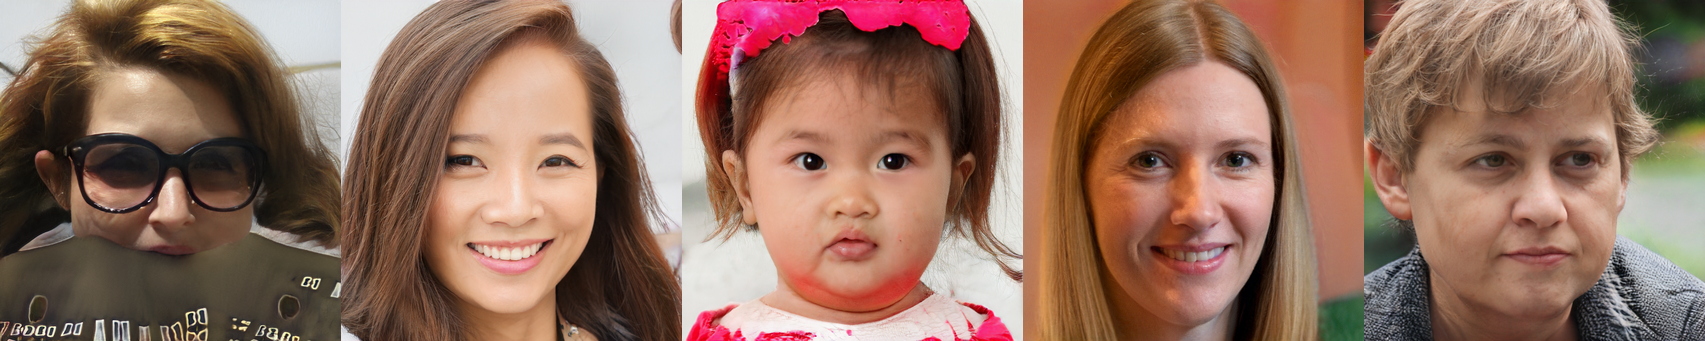

Training:  60%|██████    | 300/500 [01:57<01:17,  2.57it/s, loss=-0.1548]

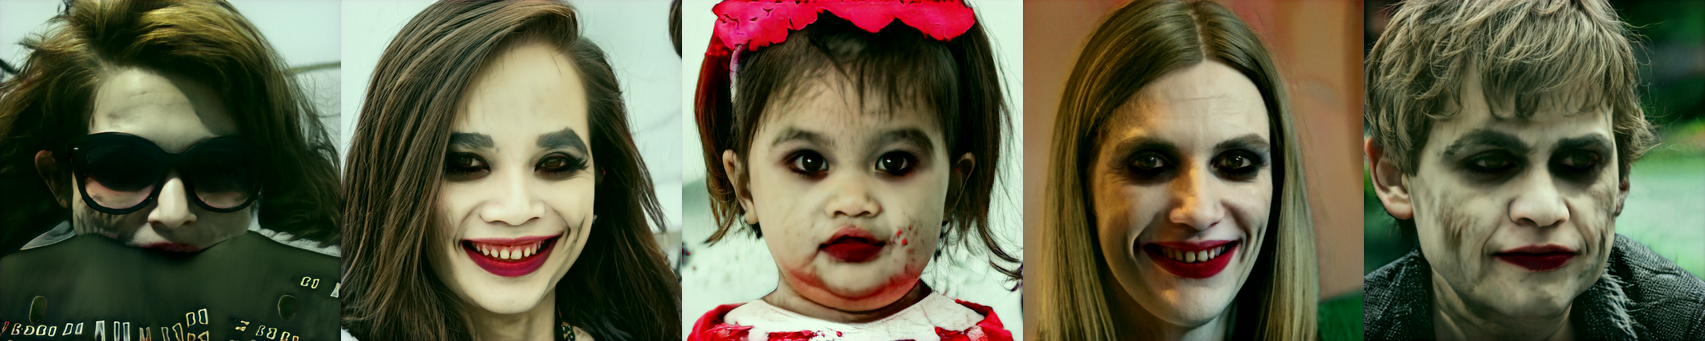

Training: 100%|█████████▉| 499/500 [03:15<00:00,  2.52it/s, loss=-0.1753]

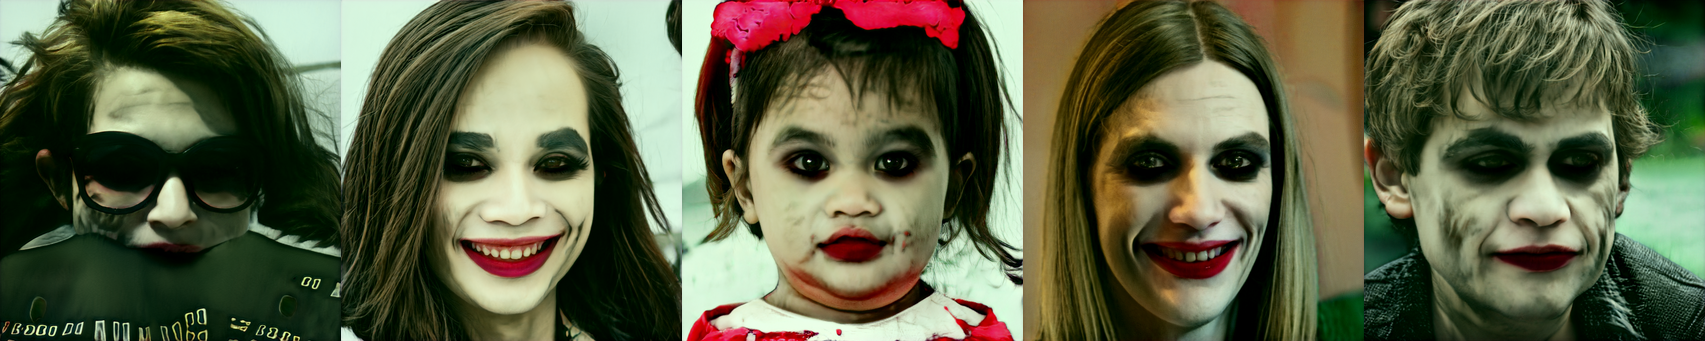

Training: 100%|██████████| 500/500 [03:16<00:00,  2.54it/s, loss=-0.1753]


In [43]:
# ------------------------------
# ЦИКЛ ОБУЧЕНИЯ С ВИЗУАЛИЗАЦИЕЙ
# ------------------------------

fixed_z = torch.randn(5, latent_dim, device=device)
pbar = tqdm(range(steps), desc="Training")

for step_i in pbar:
    optimizer.zero_grad()

    z = torch.randn(batch_size, latent_dim, device=device)
    generated_imgs, _ = generator([z], truncation=1, input_is_latent=False)

    clip_in = clip_preprocess_tensor(generated_imgs)
    image_embeds = clip_model.encode_image(clip_in)
    image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)

    target_sim = (image_embeds * text_target_emb).sum(dim=-1)
    orig_sim   = (image_embeds * text_orig_emb).sum(dim=-1)

    clip_loss = - (target_sim - alpha * orig_sim).mean()
    clip_loss.backward()
    optimizer.step()

    clip_loss_val = clip_loss.item()
    pbar.set_postfix({"loss": f"{clip_loss_val:.4f}"})

    if step_i % 300 == 0 or step_i == steps - 1:
        with torch.no_grad():
            fixed_imgs, _ = generator([fixed_z], truncation=1, input_is_latent=False)

        pil_list = []
        for idx in range(5):
            preview_img = fixed_imgs[idx].detach().cpu()
            preview_img = (preview_img.clamp(-1,1) + 1)/2
            preview_img = (preview_img * 255).permute(1,2,0).numpy().astype(np.uint8)
            pil_img = Image.fromarray(preview_img)
            pil_list.append(pil_img)

        merged_img = merge_images_horizontally(pil_list, scale_factor=1/3)
        save_path = os.path.join(outdir, f"step_{step_i}_merged.png")
        merged_img.save(save_path)
        display(merged_img)

In [44]:
# ------------------
# СОХРАНЕНИЕ МОДЕЛИ
# ------------------

final_ckpt_path = os.path.join(outdir, "stylegan2_nada_final.pt")
torch.save({"g_ema": generator.state_dict()}, final_ckpt_path)
print("Done! Final checkpoint saved to:", final_ckpt_path)

Done! Final checkpoint saved to: content/outputs_nada_colab/stylegan2_nada_final.pt


<ipython-input-45-228ee5dc67e5>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


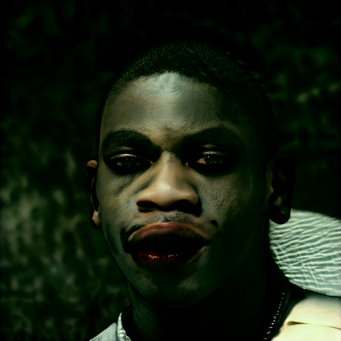

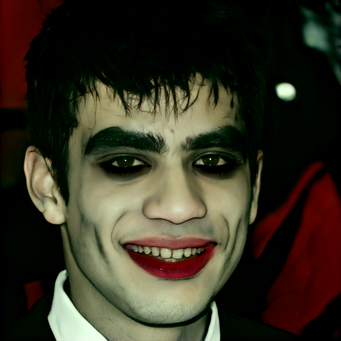

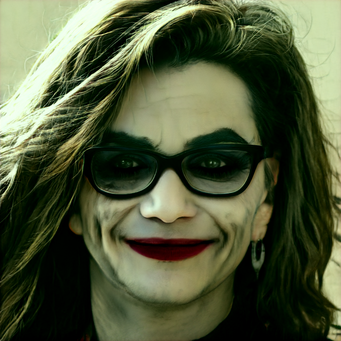

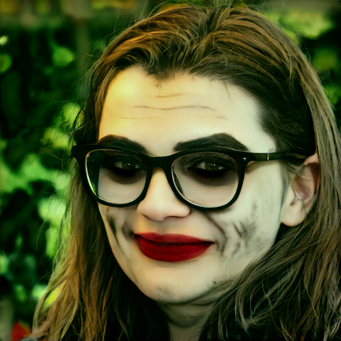

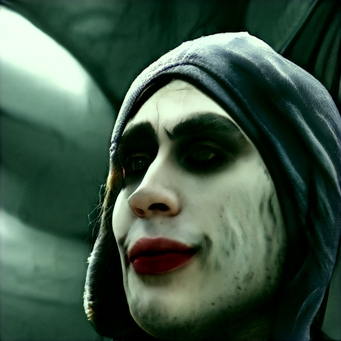

In [45]:
# ------------------------
# ГЕНЕРАЦИЯ StyleGAN-NADA
# ------------------------

ckpt_path = "content/outputs_nada_colab/stylegan2_nada_final.pt"
checkpoint = torch.load(ckpt_path, map_location=device)
generator.load_state_dict(checkpoint["g_ema"])

generator.eval()
with torch.no_grad():
    for i in range(5):
        z = torch.randn(1, latent_dim, device=device)

        img, _ = generator([z], truncation=1, input_is_latent=False)
        img = (img.clamp(-1, 1) + 1) / 2
        img = (img * 255).permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)[0]
        pil_img = Image.fromarray(img)
        scale_factor = 1/3
        w, h = pil_img.size
        new_w, new_h = int(w * scale_factor), int(h * scale_factor)
        pil_img_small = pil_img.resize((new_w, new_h), Image.LANCZOS)
        display(pil_img_small)